<a href="https://colab.research.google.com/github/datascientist-hist/Spam_Messages_Classification/blob/main/Spam_Messages_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Email Spam Classification

## Goal

The aim of this project is to classify emails into spam and non-spam email 

To do this I will use the frequencies method ,that will count the how many different words there are in a sentence after that I will choose a number of relevant words.Below I will expalin better the method



##Preparing environment and dataset

In [187]:
! pip install plotly_express

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/




#Loading Library

In [188]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly_express as px
import plotly.figure_factory as ff
from wordcloud import WordCloud
import nltk
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

#Loading Dataset

Dataset has been downloaded from kaggle.

You can see more info in the link below

https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

In [189]:
data=pd.read_csv('Spam_Classification.csv')

In [190]:
print(data.shape)
print(data.columns)

(5572, 2)
Index(['Category', 'Message'], dtype='object')


In [191]:
data.head(10)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


#EDA 
I am going to obtain a general overview of the dataset using graphs and adding also a new feature *length* that describes the  number of characters of each email


In [192]:
data['Category'].value_counts().to_dict()

{'ham': 4825, 'spam': 747}

In [193]:
fig = px.histogram(data, x="Category", color="Category",
                   color_discrete_sequence=['#003f5c', '#ffa600'])
fig.show()

In [194]:
data['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

The dataset is unbalanced, we can observe that there are:
- 747 observations as Spam
- 4825 observations as ham

In [195]:
#apply len columns to entire dataset and for train and test dataset
data['length'] = data['Message'].apply(len)

In [196]:
data.head()

,Category,Message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Here we will observe if there are difference in length between email spam and not

In [197]:

lis=[data.length[data['Category']=='ham'], data.length[data['Category']=='spam']]
group_labels=['ham','spam']
colors = ['#003f5c', '#ffa600']
# Create distplot 
fig = ff.create_distplot(lis, group_labels, bin_size=20,show_rug=False,
                         curve_type='kde', # override default 'kde'
                         colors=colors)

# Add title
fig.update_layout(xaxis_range=[0,300])
fig.update_layout(title_text='Distplot with Normal Distribution')
fig.show()

In [198]:

mean_spam=data.length[data['Category']=='spam'].mean()
mean_ham=data.length[data['Category']=='ham'].mean()

sd_spam=data.length[data['Category']=='spam'].std()
sd_ham=data.length[data['Category']=='ham'].std()

print('the average length for spam is :',round(mean_spam,2),'with standard deviation :',sd_spam)
print('the average length for ham is :',round(mean_ham,2),'with standard deviation :',sd_ham)

the average length for spam is : 137.99 with standard deviation : 29.9802865150208
the average length for ham is : 71.45 with standard deviation : 58.4348642857575


From the above  distributions plot we can observe that *length* is a powerful feature since is able to provide an useful information 

#Feature Engineering

## Preprocess the data

In this phase first I will perform the following steps:
- convert tha label feature in numerical feature 
- convert web addresses into abbreviation 'wb'
- convert  phone numbers into abbreviation 'pn'
- convert  numbers into abbreviation 'p'
-  encode  money symbols into abbreviation 'ms'
- remove punctuation and white spaces
- convert all text to lowercase

In [199]:
data['class_label'] = data['Category'].map( {'spam': 1, 'ham': 0})

In [200]:
# Replace email address with 'emailaddress'

data['Message'] = data['Message'].str.replace(r"[\w.+-]+@[\w-]+\.[\w.-]+", '  em  ')

# Replace urls with 'webaddress'
data['Message'] = data['Message'].str.replace(r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])', '  wb ')

# Replace money symbol with 'money-symbol'
data['Message'] = data['Message'].str.replace(r'£|\$', '  ms  ')

# Replace 10 digit phone number with 'phone-number'
data['Message'] = data['Message'].str.replace(r'(\d{3}\d{3}\d{4})', '  pn  ' )

# Replace normal number with 'number'
data['Message'] = data['Message'].str.replace(r'\d+(\.\d+)?', '  n  ')

# remove punctuation
data['Message'] = data['Message'].str.replace(r'[^\w\d\s]', ' ')

# remove whitespace between terms with single space
data['Message'] = data['Message'].str.replace(r'\s+', ' ')

# remove leading and trailing whitespace
data['Message'] = data['Message'].str.replace(r'^\s+|\s*?$', ' ')

# change words to lower case
data['Message'] = data['Message'].str.lower()

## Removing StopWords

Going forward, I'll remove stopwords from the message content. Stop words are words that search engines have been programmed to ignore, such as “the”, “a”, “an”, “in”, "but", "because" etc.,we can resume stopwords as words that don't have a meaning when they are used alone

In [201]:
data['Message'].iloc[0:10]

0    go until jurong point crazy available only in ...
1                            ok lar joking wif u oni  
2    free entry in n a wkly comp to win fa cup fina...
3        u dun say so early hor u c already then say  
4    nah i don t think he goes to usf he lives arou...
5    freemsg hey there darling it s been n week s n...
6    even my brother is not like to speak with me t...
7    as per your request melle melle oru minnaminun...
8    winner as a valued network customer you have b...
9    had your mobile n months or more u r entitled ...
Name: Message, dtype: object

In [202]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [203]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [204]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
data['Message'] = data['Message'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

## Stemming

Next, I will extract the base form of words by removing affixes from them. This called stemming,there are numerous stemming algorithms,i'll use Snowball Stemmer


<a href="https://ibb.co/RpqbT1p"><img src="https://i.ibb.co/nsFmMTs/stopword.png" alt="stopword" border="0"></a>

In [205]:
ss = nltk.SnowballStemmer("english")
data['Message'] = data['Message'].apply(lambda x: ' '.join(ss.stem(term) for term in x.split()))


## Count Vectors

Machine learning algorithms cannot work with raw text directly. The text must be converted into numbers.
First, we create a Bag of Words (BOW) model to extract features from text:

This algorithm is very similar to the one-hot encoding, but it has the advantage of identifying the frequency/counts of the words in the documents they appear.

- Step 1:Convert each document into a sequence of words containing that document.

- Step 2: From the set of all the words in the corpus, count how often the word occurs in the document.

<a href="https://ibb.co/xJmcBt6"><img src="https://i.ibb.co/dGb3VwD/bag-of-words.png" alt="bag-of-words" border="0"></a>

In [206]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [207]:
from sklearn.feature_extraction.text import CountVectorizer

sms_df = data['Message']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(sms_df)
#print(vectorizer.get_feature_names())


In [208]:

print(len(X.toarray()[0]))
count_words=pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
count_words['label']=data['class_label']
count_words.head()


6279


,____,aa,aah,aaniy,aaooooright,aathi,ab,abbey,abdomen,abeg,abel,aberdeen,abi,abil,abiola,abj,abl,abnorm,abouta,abroad,absenc,absolut,abstract,abt,abta,aburo,abus,ac,academ,acc,accent,accentur,accept,access,accid,accident,accommod,accommodationvouch,accomod,accord,accordin,account,accumul,ach,achan,achiev,acid,acknowledg,acl,acnt,...,ymca,yo,yoga,yogasana,yor,yorg,youdo,youi,young,younger,youphon,your,yourinclus,yourjob,youuuuu,youwanna,yovill,yowif,yoyyooo,yr,yrs,ystrday,yt,ything,yummi,yummmm,yun,yunni,yuo,yuou,yup,yupz,zac,zaher,zealand,zebra,zed,zero,zf,zhong,zindgi,zoe,zogtorius,zoom,zouk,zs,zyada,èn,〨ud,label
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##Showing most used word in spam emails

In [209]:
#Searching  the 100 most frequent words in spam emails

df_spam=count_words[count_words['label']==1].sum()
df_spam.sort_values(ascending=False,inplace=True)
df_spam.drop('label',inplace=True)
spam_words=df_spam.iloc[0:100]

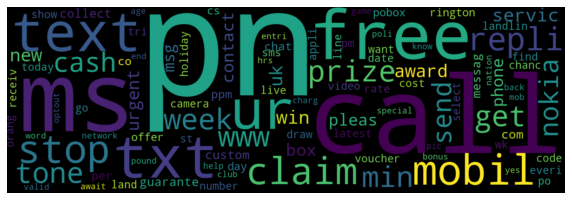

In [210]:
#Showing the  100 most used word in spam emails
wc = WordCloud(width=1200, height=400, max_words=200).generate_from_frequencies(spam_words.to_dict())

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

##Showing most used word in ham emails

In [211]:
#Searching  the 100 most frequent words in ham emails

df_ham=count_words[count_words['label']==0].sum()
df_ham.sort_values(ascending=False,inplace=True)
df_ham.drop('label',inplace=True)
ham_words=df_ham.iloc[0:100]

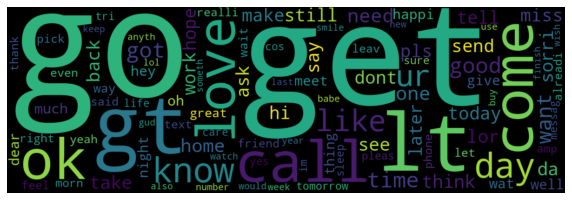

In [212]:
#Showing the  100 most used word in ham emails
wc = WordCloud(width=1200, height=400, max_words=200).generate_from_frequencies(ham_words.to_dict())

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

After that I searched the most used words for each category ,i will create a Bag of Word only with  that in order to reduce the number of variable that the model should  to handle

In [213]:
#columns to maintain
col= [*spam_words.index,*ham_words.index]
print(len(col))
#removing duplicate word
col = [*set(col)]
print(len(col))


200
181


In [214]:
#filtering columns from count_words dataframe
count_words=count_words[col]
count_words.shape


(5572, 181)

In [215]:
count_words['length']=data['length']
count_words['label']=data['class_label']

In [216]:
count_words.shape

(5572, 183)

# Splitting data

In [217]:
from sklearn.model_selection import train_test_split

In [218]:
data.columns

Index(['Category', 'Message', 'length', 'class_label'], dtype='object')

In [219]:

Y=data['class_label']
X=count_words.drop('label',axis=1)


In [220]:
X_train, X_test, y_train, y_test = train_test_split(
     X, Y, test_size=0.33, random_state=2,stratify=Y)

In [221]:
X.head()

,game,hrs,sleep,cash,rington,dear,last,sms,lol,got,give,buy,later,guarante,much,win,send,await,thank,happi,live,po,go,urgent,back,club,thing,show,pleas,award,meet,cos,pic,need,finish,per,nation,ok,home,network,right,said,pm,good,orang,appli,ms,ask,valid,lor,...,servic,care,life,night,poli,dont,com,call,ur,landlin,video,phone,date,help,leav,latest,code,wat,tell,collect,line,land,miss,ppm,gud,special,camera,word,charg,hope,msg,well,gt,amp,pls,cs,tomorrow,custom,say,love,pn,morn,know,day,yeah,st,nokia,prize,one,length
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,111
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,155
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,49
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61


# Training Models
I will use the following models:

|Model|Accuracy  test set|
|-----|--------|
|Naive Bayes| 95,81%|
|Logistic Regression| 97.82%|
|**Random Forest**| 98.42%| 
|Support Vector Classifier| 86.56%| 
|Voting Classifier |97.98%|





In [222]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn import metrics

In [223]:
def clf_metrics(classifier,model_name):
    classifier=classifier.fit(X_train,y_train)
    #Precision score over 2.5 and under 2.5
    y_pred=pd.Series(classifier.predict(X_test))
    precision_positive = metrics.precision_score(y_test, y_pred, pos_label=1)*100
    precision_negative = metrics.precision_score(y_test, y_pred, pos_label=0)*100
    accuracy=metrics.accuracy_score(y_test, y_pred)*100
    print(model_name)
    print('\n')
    print(f"Precision score spam:  {precision_positive}\nPrecision score ham:  {precision_negative}\nAccuracy:  {accuracy}")
    return classifier


In [224]:
#I usually use Naive Bayes as a baseline for my classification tasks 
gnb = GaussianNB()
cv = cross_val_score(gnb,X_train,y_train,cv=5)
print(cv)
print(cv.mean())
clf_metrics(gnb,'GaussianNB')

[0.96519411 0.95046854 0.95983936 0.94504021 0.9691689 ]
0.957942224662726
GaussianNB


Precision score spam:  78.33333333333333
Precision score ham:  99.22027290448344
Accuracy:  95.81294181620446


GaussianNB()

In [225]:
lr = LogisticRegression(max_iter = 2000,random_state=1)
cv = cross_val_score(lr,X_train,y_train,cv=5)
print(cv)
print(cv.mean())
clf_metrics(lr,'Logistic Regression')

[0.97991968 0.97188755 0.98393574 0.98927614 0.98123324]
0.9812504710531134
Logistic Regression


Precision score spam:  97.6958525345622
Precision score ham:  97.84217016029592
Accuracy:  97.82490483958674


LogisticRegression(max_iter=2000, random_state=1)

In [226]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_train,y_train,cv=5)
print(cv)
print(cv.mean())
rf=clf_metrics(rf,'Random Forest')

[0.97590361 0.97858099 0.98527443 0.98391421 0.97587131]
0.9799089117865565
Random Forest


Precision score spam:  98.23008849557522
Precision score ham:  98.45009299442033
Accuracy:  98.42305600870039


In [227]:
svc = SVC(random_state = 1)
cv = cross_val_score(svc,X_train,y_train,cv=5)
print(cv)
print(cv.mean())
print('\n')
clf_metrics(svc,'Support Vector Classifier')

[0.86613119 0.86613119 0.86613119 0.86595174 0.86595174]
0.8660594119103762


Support Vector Classifier


Precision score spam:  0.0
Precision score ham:  86.56878738444806
Accuracy:  86.56878738444806


SVC(random_state=1)

In [228]:
#Voting classifier takes all of the inputs and averages the results. For a "hard" voting classifier each classifier gets 1 vote "yes" or "no" and the result is just a popular vote. For this, you generally want odd numbers
#A "soft" classifier averages the confidence of each of the models. If a the average confidence is > 50% that it is a 1 it will be counted as such
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('lr',lr),('rf',rf),('svc',svc)], voting = 'hard') 
cv = cross_val_score(voting_clf,X_train,y_train,cv=5)
print(cv)
print(cv.mean())
clf_metrics(voting_clf,'voting classifeier')

[0.9772423  0.97322624 0.98393574 0.98525469 0.97453083]
0.9788379613180156
voting classifeier


Precision score spam:  99.52830188679245
Precision score ham:  97.78733866011063
Accuracy:  97.98803697661774


VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=2000,
                                                 random_state=1)),
                             ('rf', RandomForestClassifier(random_state=1)),
                             ('svc', SVC(random_state=1))])

At this point before moving on I should choose the model to analyze,in
this case i will take into account only the accuracy on the test set to choose the model  (but I could also consider 'recall','precision' and others metrics),for this reason i will choose 
**Random Forest**


# Model's features

Showing the features of the Random Forest classifier

In [229]:
clf_metrics(rf,'Random Forest')

Random Forest


Precision score spam:  98.23008849557522
Precision score ham:  98.45009299442033
Accuracy:  98.42305600870039


RandomForestClassifier(random_state=1)

In [230]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [231]:
best_rf = rf

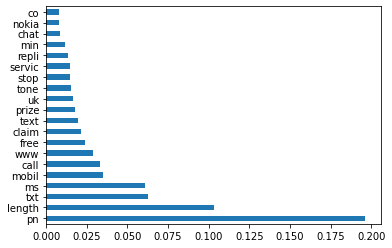

In [232]:
feat_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [233]:
predrf=best_rf.predict(X_test)

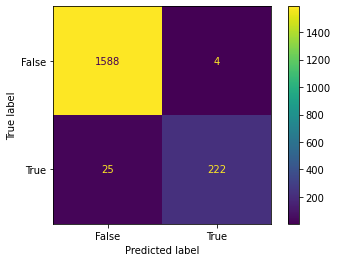

In [234]:
#Misclassification Error PredB365
confusion_matrix = metrics.confusion_matrix(y_test,predrf)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

# Saving model with pickle

Pickle is the standard way of serializing objects in Python.

We can use the pickle operation to serialize our machine learning algorithms and save the serialized format to a file.

In [235]:
import pickle

In [236]:
# save the model (98.20 % accuracy) to disk
filename = 'spam_classifier_model.sav'
pickle.dump(best_rf, open(filename, 'wb'))


In [237]:
#save also the columns useful for the data
col=X.columns
with open('columns.sav', 'wb') as f:    #Pickling
     pickle.dump(col, f)

In [238]:
with open("columns.sav", "rb") as fp:   #Unpickling
    cl = pickle.load(fp)


In [239]:
'''
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result) 
'''

"\n# load the model from disk\nloaded_model = pickle.load(open(filename, 'rb'))\nresult = loaded_model.score(X_test, Y_test)\nprint(result) \n"

# Deploying model

With this step i want to enclose the code to use the model
- We will ask to the user to provide an email to classify
- The we will perform a cleaning of the text
- we will use a bag of word created before
- then we will count the frequency
- at the end we will predict the class of the email :
 - 1 spam
 - 0 ham

## Entering text

In [240]:
#email=input("Enter your email to classify if it is spam or not: ")
email='Hello my name is Giuseppe and i am glad to meet you'

# Cleaning text

In [241]:
data=pd.DataFrame(data={"Message":[email]})

In [242]:
# Replace email address with 'emailaddress'

data['Message'] = data['Message'].str.replace(r"[\w.+-]+@[\w-]+\.[\w.-]+", '  em  ')

# Replace urls with 'webaddress'
data['Message'] = data['Message'].str.replace(r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])', '  wb ')

# Replace money symbol with 'money-symbol'
data['Message'] = data['Message'].str.replace(r'£|\$', '  ms  ')

# Replace 10 digit phone number with 'phone-number'
data['Message'] = data['Message'].str.replace(r'(\d{3}\d{3}\d{4})', '  pn  ' )

# Replace normal number with 'number'
data['Message'] = data['Message'].str.replace(r'\d+(\.\d+)?', '  n  ')

# remove punctuation
data['Message'] = data['Message'].str.replace(r'[^\w\d\s]', ' ')

# remove whitespace between terms with single space
data['Message'] = data['Message'].str.replace(r'\s+', ' ')

# remove leading and trailing whitespace
data['Message'] = data['Message'].str.replace(r'^\s+|\s*?$', ' ')

# change words to lower case
data['Message'] = data['Message'].str.lower()

In [243]:
data.head()

,Message
0,hello my name is giuseppe and i am glad to mee...


In [244]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [245]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
data['Message'] = data['Message'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

In [246]:
ss = nltk.SnowballStemmer("english")
data['Message'] = data['Message'].apply(lambda x: ' '.join(ss.stem(term) for term in x.split()))

In [247]:
data.head()

,Message
0,hello name giusepp glad meet


## Preparing dataset to be provided to the model

In [248]:
#Loading columns for model and create dataframe for the model
cl = pickle.load(open('columns.sav', 'rb'))
newdata = pd.DataFrame(0, index=np.arange(len(data)), columns=cl)
print(newdata.shape)
newdata.head()

(1, 182)


,game,hrs,sleep,cash,rington,dear,last,sms,lol,got,give,buy,later,guarante,much,win,send,await,thank,happi,live,po,go,urgent,back,club,thing,show,pleas,award,meet,cos,pic,need,finish,per,nation,ok,home,network,right,said,pm,good,orang,appli,ms,ask,valid,lor,...,servic,care,life,night,poli,dont,com,call,ur,landlin,video,phone,date,help,leav,latest,code,wat,tell,collect,line,land,miss,ppm,gud,special,camera,word,charg,hope,msg,well,gt,amp,pls,cs,tomorrow,custom,say,love,pn,morn,know,day,yeah,st,nokia,prize,one,length
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Preparing dataset from the text useful to update dataset for the model

In [249]:
#create dataframe from the text in input
from sklearn.feature_extraction.text import CountVectorizer

sms_df = data['Message']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(sms_df)
#print(vectorizer.get_feature_names())



In [250]:
print(len(X.toarray()[0]))
count_words=pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
count_words['length']=len(email)
count_words.head()

5


,giusepp,glad,hello,meet,name,length
0,1,1,1,1,1,51


##  Updating dataset to be provided to the model

In [251]:
#now i will overlap dataframe from text with dataframe for the model
newdata.update(count_words)
pd.set_option('display.max_columns', 100)
newdata.head() 


,game,hrs,sleep,cash,rington,dear,last,sms,lol,got,give,buy,later,guarante,much,win,send,await,thank,happi,live,po,go,urgent,back,club,thing,show,pleas,award,meet,cos,pic,need,finish,per,nation,ok,home,network,right,said,pm,good,orang,appli,ms,ask,valid,lor,...,servic,care,life,night,poli,dont,com,call,ur,landlin,video,phone,date,help,leav,latest,code,wat,tell,collect,line,land,miss,ppm,gud,special,camera,word,charg,hope,msg,well,gt,amp,pls,cs,tomorrow,custom,say,love,pn,morn,know,day,yeah,st,nokia,prize,one,length
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51


## Loading model

In [252]:
#Loading model saved
rfc = pickle.load(open('spam_classifier_model.sav', 'rb'))
#result = rfc.score(X, Y)
#print(result) 

## Classifying email

In [253]:
prediction = rfc.predict(newdata)
if(prediction ==1): print("spam")
else: print('ham')

ham


# Conclusion

I have obtained an accuracy of 98.42%  with a precision score  for spam emails of  98.23% and of 98.45% for ham emails,I can conclude saying that the model will work well with emails like in the dataset but since that modern emails have a more complex structure this model will not be useful in classifying those